In [1]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-1d541413-4067-6294-1f70-b779cedbe581)


# Introduction to NLP Fundamentals in TensorFlow

## Get helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2021-08-15 14:04:34--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-08-15 14:04:34 (46.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get a text dataset
Kaggle's introduction to NLP dataset (text samples of Tweets labeled as disaster or not disaster)

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

unzip_data('nlp_getting_started.zip')

--2021-08-15 14:04:37--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 64.233.187.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.006s  

2021-08-15 14:04:37 (104 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Become one with the data

In [4]:
import pandas as pd
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_df['text'][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [6]:
# Shuffle training data frame
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [7]:
# What does the test daataframe look like
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [9]:
# How many total samples
len(train_df), len(test_df)

(7613, 3263)

In [10]:
# Visualize random training examples
import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"target: {target}, ","real disaster" if target > 0 else"not real disaster")
  print(f"text:\n{text}\n")
  print("---\n")

target: 0,  not real disaster
text:
@justinbieber @ArianaGrande SCREAMING

---

target: 1,  real disaster
text:
#Russian food crematoria provokes outrage amid crisis famine memories http://t.co/FjeaFgbZfJ

---

target: 0,  not real disaster
text:
@Bang_Me_Up_Guk he was ;-; like he was singing so loud ;-;

---

target: 1,  real disaster
text:
Families to sue over Legionnaires: More than 40 families affected by the fatal outbreak of Legionnaires' disea... http://t.co/oJyW7jkUH5

---

target: 1,  real disaster
text:
Cleared:  Accident with property damage on #NY35 EB at NY 100

---



### Split data into training and validation sets

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # 10% of training data for validation set
                                                                            random_state=42)


In [13]:
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [14]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Converting text into numbers

* Tokenization - direct mapping of token to number
* Embedding - create a matrix of feature vector for each token (the size of the feature can be defined, and the embeddiing can be learned)

### Text vertorization (Tokenization)

In [15]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [16]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [17]:
# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary, None for no csp
                                   standardize='lower_and_strip_punctuation',
                                   split='whitespace',
                                   ngrams=None, # Treat tokens on its own
                                   output_mode='int', # How to map tokens to numbers
                                   output_sequence_length=None, # How long a seq should be
                                   pad_to_max_tokens=True)

In [18]:
train_sentences[0].split(), len(train_sentences[0].split())

(['@mogacola', '@zamtriossu', 'i', 'screamed', 'after', 'hitting', 'tweet'], 7)

In [19]:
# Find the average number of tokens (words) in the training tweet
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [20]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does a model see)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode='int',
                                    output_sequence_length=max_length)

In [21]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [22]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [23]:
len(train_sentences)

6851

In [24]:
# Choose a random from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f'Original text:\n{random_sentence}\
      \n\n Vectorized version:')
text_vectorizer([random_sentence])

Original text:
her loyalty mission involves her kicking a shitty nobleman to death???? I love this elven weirdo      

 Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  81,    1, 2042,    1,   81,    1,    3, 3423,    1,    5,  154,
           8,  110,   19,    1]])>

In [25]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in the training data
top_5_words = words_in_vocab[:5] # get the top 5 common words
least_5_words = words_in_vocab[-5:] # get the least 5 common words
print(f'Number of words in vocab: {len(words_in_vocab)}')
print(f'Most common words: {top_5_words}')
print(f'5 least common words {least_5_words}')

Number of words in vocab: 10000
Most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an embedding using an embedding layer

Using the tensorflow embedding layer...

The parameters we care most about:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for example, a value of 1-- would mean each token gets represented by a tensor 100 long
* `input_length` = length of the sequences being passed to the embedding layer

In [26]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             input_length=max_length)
embedding

In [27]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text: \n{random_sentence}\
      \n\n Embedded version")

# Embed the random sentence
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text: 
Ever since my Facebook #Mets meltdown after the Padres fiasco- mets are 6-0. You're welcome      

 Embedded version


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.02970516, -0.03103025, -0.04706411, ...,  0.00248731,
          0.02415318,  0.01162814],
        [ 0.04754016, -0.02333161, -0.04373273, ..., -0.01044548,
         -0.04505837, -0.01975262],
        [ 0.01780583, -0.041327  ,  0.02645374, ...,  0.01972861,
         -0.02018124, -0.00161278],
        ...,
        [ 0.0107576 , -0.01578578, -0.0325756 , ..., -0.0223287 ,
         -0.01782979,  0.02500958],
        [-0.0201749 , -0.04555999, -0.03717389, ...,  0.0288965 ,
          0.00727289,  0.02047117],
        [-0.04100467,  0.04278385, -0.02814034, ...,  0.04955347,
          0.00104071, -0.0366521 ]]], dtype=float32)>

In [28]:
sample_embed.shape

TensorShape([1, 15, 128])

In [29]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.02970516, -0.03103025, -0.04706411, -0.03764677, -0.0051964 ,
         0.02196312, -0.04332715, -0.00517005, -0.01369924, -0.03923353,
        -0.01929709,  0.03956134,  0.03708446,  0.01423727,  0.04146589,
         0.0195321 ,  0.0163937 ,  0.01209717, -0.03908964, -0.0441047 ,
        -0.00386799, -0.03370885, -0.04574281, -0.01450534,  0.04903198,
         0.00027836,  0.01819209,  0.00796396, -0.04334649, -0.02125719,
         0.02678904, -0.01888443, -0.04728077, -0.04735451, -0.01608117,
        -0.0195238 ,  0.00648172,  0.04783105, -0.01065857, -0.00904049,
         0.01016564, -0.01468598, -0.00114087,  0.04021632,  0.0412498 ,
        -0.01444761, -0.01071763,  0.01241652, -0.04718286, -0.02492712,
        -0.0176034 ,  0.03092651,  0.02586054,  0.00895423, -0.00492289,
         0.029991  , -0.03956572, -0.02160984,  0.00893587,  0.00337775,
         0.02930853,  0.04535775, -0.01086514,  0.02561912, -0.01701438,
  

## Modelling a text dataset (running a series of experiments)

> Check out the Scikit learn machine learning map!

We'll start with a baseline and move on from there
* Model 0: Naive Bayes (baseline)
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional-LSTM model (RNN)
* Model 5: 1D Convolutional Neural Network (CNN)
* Model 6: Tensorflow Hub Pretrained Feature Extractor (using transfer learning for NLP)
* Model 7: same as model 6 with 10% of training data



 ### Model 0: Getting a baseline

 Multinomial Naive Bayes using the TF-IDF formula to convert words to numbers

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
                    ('tfidf', TfidfVectorizer()), # Convert words to numbers
                    ('clf', MultinomialNB()) # model the text
])

model_0.fit(train_sentences, train_labels)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [31]:
train_sentences, train_labels

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        ...,
        'Near them on the sand half sunk a shattered visage lies... http://t.co/0kCCG1BT06',
        "kesabaran membuahkan hasil indah pada saat tepat! life isn't about waiting for the storm to pass it's about learning to dance in the rain.",
        "@ScottDPierce @billharris_tv @HarrisGle @Beezersun I'm forfeiting this years fantasy football pool out of fear I may win n get my ass kicked"],
       dtype=object), array([0, 0, 1, ..., 1, 1, 0]))

In [32]:
# Evaluate baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f'Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%')

Our baseline model achieves an accuracy of: 79.27%


In [33]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluation function for our model experiment

Metrics:
* Accuracy
* Precision
* Recall
* F1-

> Read: https://scikit-learn.org/stable/modules/model_evaluation.html

In [34]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  '''
  Calculate mode accuracy, precision, recal and f1 score of a binary classification model.
  '''
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
  model_results = {'accuracy': model_accuracy,
                   'precision': model_precision,
                   'recall': model_recall,
                   'f1': model_f1}
  return model_results

In [35]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 1: A simple dense model

In [36]:
# Create a tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to tensorboard logs
SAVE_DIR = 'model_logs'

In [37]:
# Build model with the functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string) # 1-D strings
x = text_vectorizer(inputs)
x = embedding(x) # create an embedding of the numberized inputs
x = layers.GlobalAveragePooling1D()(x) # condense the feature vector for each tokern to one vector
outputs = layers.Dense(1, activation='sigmoid')(x)
model_1 = tf.keras.models.Model(inputs, outputs, name='model_1_dense')

In [38]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [39]:
# Compile the model
model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [40]:
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name='model_1_dense')])

Saving TensorBoard log files to: model_logs/model_1_dense/20210815-140445
Epoch 1/5
215/215 [==============================] - 7s 25ms/step - loss: 0.6117 - accuracy: 0.6903 - val_loss: 0.5360 - val_accuracy: 0.7585
Epoch 2/5
215/215 [==============================] - 5s 22ms/step - loss: 0.4422 - accuracy: 0.8180 - val_loss: 0.4686 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 5s 22ms/step - loss: 0.3478 - accuracy: 0.8571 - val_loss: 0.4572 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 5s 22ms/step - loss: 0.2854 - accuracy: 0.8897 - val_loss: 0.4596 - val_accuracy: 0.7900
Epoch 5/5
215/215 [==============================] - 5s 21ms/step - loss: 0.2390 - accuracy: 0.9121 - val_loss: 0.4774 - val_accuracy: 0.7848


In [41]:
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 0.4774 - accuracy: 0.7848


[0.47735363245010376, 0.7847769260406494]

In [42]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

(762, 1)

In [43]:
model_1_pred_probs[:20]

array([[0.33014637],
       [0.77198136],
       [0.99748445],
       [0.11420258],
       [0.12030058],
       [0.9355305 ],
       [0.91798437],
       [0.9956254 ],
       [0.9637073 ],
       [0.24671707],
       [0.13267039],
       [0.6811306 ],
       [0.04544739],
       [0.27105242],
       [0.00603147],
       [0.12384415],
       [0.02822878],
       [0.09183289],
       [0.21818317],
       [0.52567565]], dtype=float32)

In [44]:
# Convert model prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0

In [45]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.4776902887139,
 'f1': 0.781600538849599,
 'precision': 0.7900209877855079,
 'recall': 0.7847769028871391}

In [46]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

In [47]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

## Visualizing learned embeddings

In [48]:
# Get the vocabulary from the text vectorizatio layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [49]:
# Model summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Get the weight matrix of the embedding layer
# these are the numerical representations of each token in our data, which have
# been learned for 5 epochs
embed_weights = model_1.get_layer("embedding").get_weights()[0]
print(embed_weights.shape) # same as vocab size and embedding_dim (output_dim of our embedding layer)

(10000, 128)


In [51]:
embed_weights.shape

(10000, 128)

Visualizing

https://projector.tensorflow.org/

In [52]:
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [53]:
# Download files from colab to upload to tensorflow projector
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Recurrent Neural Networks (RNN's)
RNN's are useful for sequence data.

The premise of RNN is to use the representation of a previous input to aid the representation of a later input.

### Model 2: LSTM
Recurrent layer: Long short term memory

`Input (text) -> Tokenize -> Embedding -> Layers (RNN's / dense) -> Output (label probability)`

In [54]:
# Create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # when you are stacking RNN cells together, you need to set return_sequences=True
print(x.shape)
x = layers.LSTM(64)(x)
print(x.shape)
x = layers.Dense(64, activation='relu')(x)
print(x.shape)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_2 = tf.keras.models.Model(inputs, outputs, name='model_2_LSTM')

(None, 15, 128)
(None, 15, 128)
(None, 64)
(None, 64)


In [55]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,333,633
Trainable params: 1,333,633
Non-trainable params: 0
____________________________________________

In [56]:
model_2.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [57]:
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

In [58]:
history_2 = model_2.fit(train_sentences,
                        train_labels,
                        epochs=5,
                        validation_data=(val_sentences, val_labels),
                        callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                               experiment_name='model_2_LSTM')])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20210815-140514
Epoch 1/5
215/215 [==============================] - 10s 30ms/step - loss: 0.2214 - accuracy: 0.9191 - val_loss: 0.5500 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 5s 23ms/step - loss: 0.1536 - accuracy: 0.9429 - val_loss: 0.6610 - val_accuracy: 0.7743
Epoch 3/5
215/215 [==============================] - 5s 23ms/step - loss: 0.1296 - accuracy: 0.9502 - val_loss: 0.8009 - val_accuracy: 0.7848
Epoch 4/5
215/215 [==============================] - 5s 23ms/step - loss: 0.1038 - accuracy: 0.9602 - val_loss: 0.7899 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 5s 24ms/step - loss: 0.0818 - accuracy: 0.9660 - val_loss: 1.1061 - val_accuracy: 0.7769


In [59]:
# Make predictions
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

array([[1.4642051e-02],
       [8.9443135e-01],
       [9.9998415e-01],
       [6.7392819e-02],
       [6.9964844e-05],
       [9.9987924e-01],
       [7.7252263e-01],
       [9.9999404e-01],
       [9.9997997e-01],
       [6.3639665e-01]], dtype=float32)

In [60]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [61]:
val_labels[:10]

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0])

In [62]:
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 77.69028871391076,
 'f1': 0.7754662769426549,
 'precision': 0.7775711689884918,
 'recall': 0.7769028871391076}

In [63]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 3: GRU (Gated Recurrent Unit)

The GRU cell has similar features to an LSTM cell but has less parameters

> LSTM and GRU's are capable of learning long-term dependencies using mechanism called **gates**. The gates are different tensor operations that can learn what information to add or remove to the hidden state, making short term memory less of a problem.

Reminder:  
`Input (text which means dtype='string') -> Tokenize -> Embedding -> Layers (RNN's / dense) -> Output (label probability)`

In [64]:
# Buld an RNN using the GRu cell 
from tensorflow.keras import layers
inputs_3 = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs_3)
x = embedding(x)
# x = layers.GRU(64, return_sequences=True)(x) # if you want to stack recurent layers on top of each other, set return_sequences=True
# x = layers.LSTM(64, return_sequences=True)(x)
x = layers.GRU(64)(x)
# x = layers.Dense(64, activation='relu')(x)
outputs_3 = layers.Dense(1, activation='sigmoid')(x)
model_3 = tf.keras.models.Model(inputs_3, outputs_3, name='model_3_GRU')

In [65]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
gru (GRU)                    (None, 64)                37248     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_________________________________________________________________


In [66]:
# Compile the model
model_3.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [67]:
history_3 = model_3.fit(train_sentences,
                            train_labels,
                            epochs=5,
                            validation_data=(val_sentences, val_labels),
                            callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                   'model_3_GRU')])

Saving TensorBoard log files to: model_logs/model_3_GRU/20210815-140546
Epoch 1/5
215/215 [==============================] - 9s 29ms/step - loss: 0.1592 - accuracy: 0.9378 - val_loss: 0.6541 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 5s 24ms/step - loss: 0.0845 - accuracy: 0.9693 - val_loss: 0.7795 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 5s 23ms/step - loss: 0.0727 - accuracy: 0.9718 - val_loss: 0.9268 - val_accuracy: 0.7769
Epoch 4/5
215/215 [==============================] - 5s 24ms/step - loss: 0.0608 - accuracy: 0.9721 - val_loss: 1.1608 - val_accuracy: 0.7756
Epoch 5/5
215/215 [==============================] - 5s 23ms/step - loss: 0.0530 - accuracy: 0.9781 - val_loss: 1.3245 - val_accuracy: 0.7664


In [68]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

array([[2.6516253e-04],
       [7.4090058e-01],
       [9.9983346e-01],
       [8.6017862e-02],
       [8.8463727e-05],
       [9.9980897e-01],
       [7.1089119e-01],
       [9.9995887e-01],
       [9.9989450e-01],
       [9.8695326e-01]], dtype=float32)

In [69]:
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [70]:
val_labels[:10]

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0])

In [71]:
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 76.64041994750657,
 'f1': 0.7646647680054942,
 'precision': 0.7672473559947978,
 'recall': 0.7664041994750657}

In [72]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 4: Bidirectinal RNN

In [73]:
from tensorflow.keras import layers
inputs_4 = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs_4)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(64))(x)
outputs_4 = layers.Dense(1, activation='sigmoid')(x)
model_4 = tf.keras.models.Model(inputs_4, outputs_4)

In [74]:
model_4.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 15, 128)           98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               74496     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 1,453,441
Trainable params: 1,453,441
Non-trainable params: 0
___________________________________________________

In [75]:
model_4.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [76]:
model_4.fit(train_sentences,
            train_labels,
            epochs=5,
            validation_data=(val_sentences, val_labels),
            callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                   'model_4_bidirectional')])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20210815-140632
Epoch 1/5
215/215 [==============================] - 16s 43ms/step - loss: 0.1039 - accuracy: 0.9676 - val_loss: 0.8714 - val_accuracy: 0.7559
Epoch 2/5
215/215 [==============================] - 7s 31ms/step - loss: 0.0566 - accuracy: 0.9766 - val_loss: 1.0829 - val_accuracy: 0.7638
Epoch 3/5
215/215 [==============================] - 7s 30ms/step - loss: 0.0460 - accuracy: 0.9799 - val_loss: 1.5141 - val_accuracy: 0.7598
Epoch 4/5
215/215 [==============================] - 7s 31ms/step - loss: 0.0423 - accuracy: 0.9800 - val_loss: 1.5263 - val_accuracy: 0.7598
Epoch 5/5
215/215 [==============================] - 7s 31ms/step - loss: 0.0434 - accuracy: 0.9801 - val_loss: 1.4466 - val_accuracy: 0.7612


In [77]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

array([[6.5334811e-04],
       [7.6188511e-01],
       [9.9988294e-01],
       [1.4288633e-01],
       [5.3465315e-06],
       [9.9937004e-01],
       [4.2191140e-02],
       [9.9996841e-01],
       [9.9993134e-01],
       [5.3169817e-01]], dtype=float32)

In [78]:
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 1.], dtype=float32)>

In [79]:
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 76.11548556430446,
 'f1': 0.7588524417705016,
 'precision': 0.7627664723727715,
 'recall': 0.7611548556430446}

In [80]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

## Convolutional Neural Networks for Text (and other types of sequences)
`Inputs (text) -> Tokenize -> Embedding ->Layer(s) (typically Conv1D + pooling) -> Outputs -> (class probabilities)`

### Model 5: Conv1D

In [81]:
# Test out embedding layer, Conv1D layer and max pooling
from tensorflow.keras import layers
embedding_test = embedding(text_vectorizer(['This is a test sentence']))
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5, # this is also referred to an ngram of 5 (meaning it looks at 5 words at a time)
                        strides=1, # default
                        activation='relu',
                        padding='valid') # default = 'valid', the output is smaller than the input shape,'same' means output is same shape as input
conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # get the most important feature or get the feature with the highest value
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [82]:
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.00465568,  0.02027347,  0.05207498, ..., -0.02325166,
         -0.00695391, -0.01990177],
        [ 0.00645335, -0.03060731,  0.06089679, ...,  0.04725635,
          0.08804592,  0.02337976],
        [-0.03129666, -0.06041233,  0.08088212, ...,  0.03977767,
          0.05356771, -0.07418021],
        ...,
        [ 0.01837993, -0.02351713, -0.00212402, ...,  0.01266123,
         -0.01862502, -0.02193818],
        [ 0.01837993, -0.02351713, -0.00212402, ...,  0.01266123,
         -0.01862502, -0.02193818],
        [ 0.01837993, -0.02351713, -0.00212402, ...,  0.01266123,
         -0.01862502, -0.02193818]]], dtype=float32)>

In [83]:
conv_1d_output

<tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
array([[[0.00351453, 0.105324  , 0.        , 0.        , 0.13316944,
         0.        , 0.01500408, 0.        , 0.        , 0.05277992,
         0.04903883, 0.02184724, 0.        , 0.0236588 , 0.02505723,
         0.04770736, 0.0656759 , 0.        , 0.        , 0.        ,
         0.0660997 , 0.00888235, 0.0239083 , 0.        , 0.        ,
         0.        , 0.        , 0.04520069, 0.00997529, 0.0269706 ,
         0.        , 0.        ],
        [0.04952853, 0.        , 0.        , 0.04693423, 0.        ,
         0.        , 0.        , 0.02178522, 0.        , 0.        ,
         0.        , 0.        , 0.01694378, 0.02404773, 0.09679785,
         0.        , 0.        , 0.02390558, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.03467283, 0.00557757,
         0.        , 0.01308273, 0.00810444, 0.03913828, 0.11516362,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.    

In [84]:
max_pool_output

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[0.04952853, 0.105324  , 0.01670697, 0.04693423, 0.13316944,
        0.03378037, 0.02695296, 0.04540986, 0.00352988, 0.09619203,
        0.09630382, 0.02184724, 0.01979195, 0.0590933 , 0.09679785,
        0.04992509, 0.0656759 , 0.02390558, 0.04670061, 0.03524651,
        0.0660997 , 0.02767036, 0.0239083 , 0.08654788, 0.00557757,
        0.        , 0.01631645, 0.04653456, 0.03913828, 0.11516362,
        0.02511953, 0.00416985]], dtype=float32)>

In [85]:
# Create 1D convolutional layer to model sequences
from tensorflow.keras import layers
inputs_5 = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs_5)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1, activation='relu')(x)
x = layers.GlobalMaxPool1D()(x)
outputs_5 = layers.Dense(1, activation='sigmoid', name='output_layer')(x)
model_5 = tf.keras.models.Model(inputs_5, outputs_5, name='model_5_conv1d')

In [86]:
model_5.summary()

Model: "model_5_conv1d"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 64)            41024     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 65        
Total params: 1,321,089
Trainable params: 1,321,089
Non-trainable params: 0
__________________________________________

In [87]:
model_5.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [88]:
# Fit the model
history_5 = model_5.fit(train_sentences,
                        train_labels,
                        epochs=5,
                        validation_data=(val_sentences, val_labels),
                        callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                               'Conv1D')])

Saving TensorBoard log files to: model_logs/Conv1D/20210815-140729
Epoch 1/5
215/215 [==============================] - 7s 27ms/step - loss: 0.1290 - accuracy: 0.9508 - val_loss: 0.9188 - val_accuracy: 0.7651
Epoch 2/5
215/215 [==============================] - 5s 22ms/step - loss: 0.0766 - accuracy: 0.9720 - val_loss: 1.0241 - val_accuracy: 0.7638
Epoch 3/5
215/215 [==============================] - 5s 23ms/step - loss: 0.0606 - accuracy: 0.9753 - val_loss: 1.1722 - val_accuracy: 0.7638
Epoch 4/5
215/215 [==============================] - 5s 23ms/step - loss: 0.0540 - accuracy: 0.9788 - val_loss: 1.1834 - val_accuracy: 0.7625
Epoch 5/5
215/215 [==============================] - 5s 22ms/step - loss: 0.0509 - accuracy: 0.9800 - val_loss: 1.2193 - val_accuracy: 0.7572


In [89]:
# Make some predictions
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

array([[1.4010306e-01],
       [6.2061691e-01],
       [9.9988627e-01],
       [7.2288692e-02],
       [3.7627476e-07],
       [9.9600190e-01],
       [9.8947108e-01],
       [9.9998224e-01],
       [9.9999964e-01],
       [9.5737207e-01]], dtype=float32)

In [90]:
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [91]:
val_labels[:10]

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0])

In [92]:
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)

In [93]:
model_5_results

{'accuracy': 75.7217847769029,
 'f1': 0.7555947144839635,
 'precision': 0.7576149234046069,
 'recall': 0.7572178477690289}

In [94]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 6: Tensorflow Hub Pretrained Sentence Encoder

In [95]:
import tensorflow_hub as hub
embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')
embed_samples = embed([sample_sentence,
                       "When you use the universal sentence encoder on a sentence, it turns it into numbers."])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157032  0.02485909  0.02878048 -0.01271501  0.03971539  0.0882776
  0.02680985  0.05589837 -0.0106873  -0.00597291  0.00639325 -0.0181952
  0.00030816  0.09105889  0.05874643 -0.03180627  0.01512473 -0.05162929
  0.00991365 -0.06865346 -0.04209305  0.02678981  0.03011008  0.00321067
 -0.0033797  -0.04787361  0.02266722 -0.00985925 -0.04063613 -0.0129209
 -0.04666385  0.056303   -0.03949255  0.00517688  0.02495828 -0.07014443
  0.02871508  0.04947681 -0.00633976 -0.08960193  0.02807116 -0.00808363
 -0.01360604  0.0599865  -0.10361787 -0.05195372  0.00232956 -0.02332528
 -0.03758106  0.03327731], shape=(50,), dtype=float32)


In [96]:
embed_samples

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[-0.01157032,  0.02485909,  0.02878048, ..., -0.00186123,
         0.02315825, -0.01485021],
       [ 0.02308458, -0.08581633, -0.01775318, ..., -0.01975611,
         0.03708495, -0.00700186]], dtype=float32)>

In [97]:
# Create a Keras layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name='USE')

In [98]:
# Create model using the sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(64, activation='relu'),
  layers.Dense(1, activation='sigmoid', name='output_layer'),
], name='model_6_USE')

In [99]:
model_6.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [100]:
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_5 (Dense)              (None, 64)                32832     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [101]:
model_6_history = model_6.fit(train_sentences,
                            train_labels,
                            epochs=5,
                            validation_data=(val_sentences, val_labels),
                            callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                  'model_6_USE_feature_extract')])

Saving TensorBoard log files to: model_logs/model_6_USE_feature_extract/20210815-140847
Epoch 1/5
215/215 [==============================] - 10s 34ms/step - loss: 0.5026 - accuracy: 0.7778 - val_loss: 0.4464 - val_accuracy: 0.7953
Epoch 2/5
215/215 [==============================] - 4s 17ms/step - loss: 0.4144 - accuracy: 0.8145 - val_loss: 0.4374 - val_accuracy: 0.8110
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.4009 - accuracy: 0.8250 - val_loss: 0.4317 - val_accuracy: 0.8097
Epoch 4/5
215/215 [==============================] - 4s 17ms/step - loss: 0.3921 - accuracy: 0.8275 - val_loss: 0.4280 - val_accuracy: 0.8136
Epoch 5/5
215/215 [==============================] - 4s 17ms/step - loss: 0.3858 - accuracy: 0.8302 - val_loss: 0.4250 - val_accuracy: 0.8163


In [102]:
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.18787408],
       [0.8150799 ],
       [0.99163765],
       [0.20301096],
       [0.7209704 ],
       [0.7969692 ],
       [0.9893869 ],
       [0.9839807 ],
       [0.95285636],
       [0.10003711]], dtype=float32)

In [103]:
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [104]:
val_labels[:10]

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0])

In [105]:
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)

In [106]:
model_6_results

{'accuracy': 81.62729658792651,
 'f1': 0.8155798306901777,
 'precision': 0.8165313049719621,
 'recall': 0.8162729658792651}

In [107]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [108]:
len(train_sentences)

6851

### Model number 7: TF Hub Pretrained USE but with 10% of training data

In [109]:
train_df_shuffled

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0
...,...,...,...,...,...
5226,7470,obliteration,Merica!,@Eganator2000 There aren't many Obliteration s...,0
5390,7691,panic,NaN,just had a panic attack bc I don't have enough...,0
860,1242,blood,NaN,Omron HEM-712C Automatic Blood Pressure Monito...,0
7603,10862,NaN,NaN,Officials say a quarantine is in place at an A...,1


In [110]:
# ## NOTE: Making data splits like below leads to data leakage (model_7 trained on 10% data, outperforms model_6 trained on 100% data)
# ## DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SETS INTO TRAINING SET 

# # Create subsets of 10% of the training data
# train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
# # train_10_percent.head(), len(train_10_percent)
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

In [111]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [112]:
# Check the number of each label in the updated training data subset
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [113]:
# Check the number of targets in our subset of data
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [114]:
# Let's build a model the same as model_6
# model_7 = tf.keras.models.clone_model(model_6)
model_7 = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid", name="output_layer")                               
], name="model_7_USE")

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_7_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_6 (Dense)              (None, 64)                32832     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [115]:
# Fit the model to the 10% training data subsets
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder_10_percent_correct_split")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent_correct_split/20210815-140933
Epoch 1/5
22/22 [==============================] - 4s 124ms/step - loss: 0.6645 - accuracy: 0.7051 - val_loss: 0.6390 - val_accuracy: 0.7467
Epoch 2/5
22/22 [==============================] - 1s 46ms/step - loss: 0.5890 - accuracy: 0.8044 - val_loss: 0.5832 - val_accuracy: 0.7625
Epoch 3/5
22/22 [==============================] - 1s 30ms/step - loss: 0.5142 - accuracy: 0.8204 - val_loss: 0.5307 - val_accuracy: 0.7808
Epoch 4/5
22/22 [==============================] - 1s 30ms/step - loss: 0.4571 - accuracy: 0.8248 - val_loss: 0.5012 - val_accuracy: 0.7756
Epoch 5/5
22/22 [==============================] - 1s 32ms/step - loss: 0.4178 - accuracy: 0.8321 - val_loss: 0.4891 - val_accuracy: 0.7795


In [116]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

array([[0.20733635],
       [0.5695165 ],
       [0.90507853],
       [0.36799383],
       [0.5424048 ],
       [0.7146026 ],
       [0.87566483],
       [0.78648037],
       [0.8249807 ],
       [0.14946362]], dtype=float32)

In [117]:
# Turn pred probs into labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [118]:
# Evalaute model 7 predictions
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 77.95275590551181,
 'f1': 0.7775281328700309,
 'precision': 0.7813761276529175,
 'recall': 0.7795275590551181}

## Comparing the performance of each models

In [119]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({'0_baseline': baseline_results,
                                  '1_simple_dense': model_1_results,
                                  '2_LSTM': model_2_results,
                                  '3_GRU': model_3_results,
                                  '4_bidirectional': model_4_results,
                                  '5_conv1d': model_5_results,
                                  '6_tf_hub_use_encoder': model_6_results,
                                  '7_tf_hub_use_encoder_10_percent': model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
0_baseline,79.265092,0.811139,0.792651,0.786219
1_simple_dense,78.477690,0.790021,0.784777,0.781601
2_LSTM,77.690289,0.777571,0.776903,0.775466
3_GRU,76.640420,0.767247,0.766404,0.764665
4_bidirectional,76.115486,0.762766,0.761155,0.758852
5_conv1d,75.721785,0.757615,0.757218,0.755595
6_tf_hub_use_encoder,81.627297,0.816531,0.816273,0.815580
7_tf_hub_use_encoder_10_percent,77.952756,0.781376,0.779528,0.777528


In [120]:
# Reduce the accuracy to the same scale as other metrics
all_model_results['accuracy'] = all_model_results['accuracy']/100
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.784777,0.790021,0.784777,0.781601
2_LSTM,0.776903,0.777571,0.776903,0.775466
3_GRU,0.766404,0.767247,0.766404,0.764665
4_bidirectional,0.761155,0.762766,0.761155,0.758852
5_conv1d,0.757218,0.757615,0.757218,0.755595
6_tf_hub_use_encoder,0.816273,0.816531,0.816273,0.815580
7_tf_hub_use_encoder_10_percent,0.779528,0.781376,0.779528,0.777528


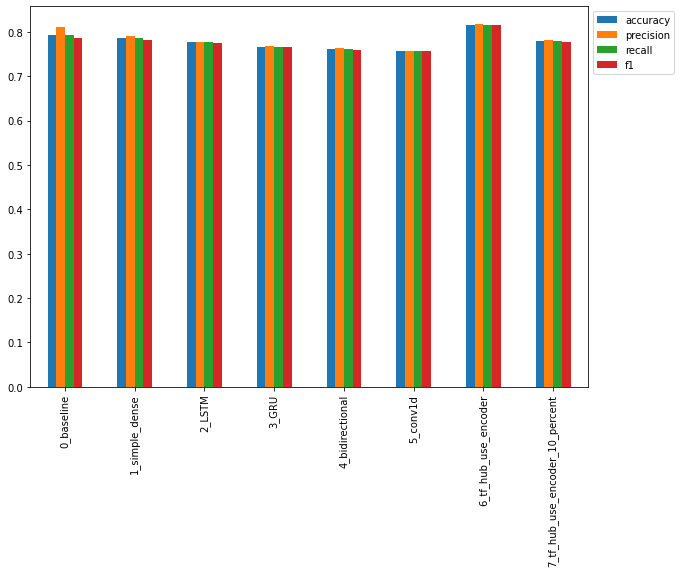

In [121]:
 # Plot and compare all of the model results
 all_model_results.plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

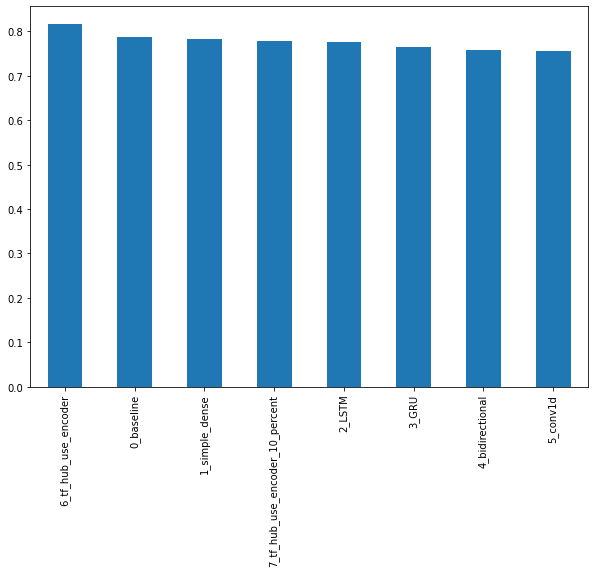

In [122]:
# Sort model results by f1-score
all_model_results.sort_values('f1', ascending=False)['f1'].plot(kind='bar', figsize=(10,7))

## Upload training logs to TensorBoard.dev

In [ ]:
!tensorboard dev upload --logdir ./model_logs/ \
--name 'NLP Modelling Experiment' \
--description 'Comparing different types of model architectures' \
--one_shot

https://tensorboard.dev/experiment/N7b4zWtvRJyX9lJyWRpCMQ/

In [ ]:
# !tensorboard dev list

In [125]:
# !tensorboard dev delete -experiment_id EXPERIMENT_ID

In [128]:
model_6_results

{'accuracy': 81.62729658792651,
 'f1': 0.8155798306901777,
 'precision': 0.8165313049719621,
 'recall': 0.8162729658792651}

## Saving and loading a trained model
1. HDF5 format
2. `SavedModel` format

In [130]:
# Save TF Hub Sentence Encoder to HDF5 format
model_6.save('model_6.h5')

In [133]:
import tensorflow_hub as hub
# Load model with custom hub layer (required with the HDF5 format)
loaded_model_6 = tf.keras.models.load_model('model_6.h5',
                                     custom_objects={'KerasLayer':hub.KerasLayer})

In [134]:
# How does our loaded model perform
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 16ms/step - loss: 0.4250 - accuracy: 0.8163


[0.4250480532646179, 0.8162729740142822]

In [135]:
model_6_results

{'accuracy': 81.62729658792651,
 'f1': 0.8155798306901777,
 'precision': 0.8165313049719621,
 'recall': 0.8162729658792651}

In [136]:
# Save TF Hub Sentence Encoder to SavedModel format
model_6.save('model_6_SavedModel_format')

INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


In [137]:
# Load in a model from the saved model format
loaded_model_6_SavedModel_format = tf.keras.models.load_model('model_6_SavedModel_format')

In [138]:
loaded_model_6_SavedModel_format.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 16ms/step - loss: 0.4250 - accuracy: 0.8163


[0.4250481426715851, 0.8162729740142822]

In [139]:
model_6_results

{'accuracy': 81.62729658792651,
 'f1': 0.8155798306901777,
 'precision': 0.8165313049719621,
 'recall': 0.8162729658792651}

## Finding the most wrong example

In [140]:
# Downlaod a pretrained model
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2021-08-15 16:12:25--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 74.125.204.128, 64.233.187.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M   118MB/s    in 8.8s    

2021-08-15 16:12:35 (104 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables.in

In [141]:
# Import model
model_6_pretrained = tf.keras.models.load_model('08_model_6_USE_feature_extractor')
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 15ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723119258880615, 0.8162729740142822]

In [142]:
# Make predictions with the loaded model from GS
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [144]:
# Create a DataFrame with validation sentences and best perfomring model predictions
val_df = pd.DataFrame({'text': val_sentences,
                       'target': val_labels,
                       'pred': model_6_pretrained_preds,
                       'pred_prob': tf.squeeze(model_6_pretrained_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [145]:
# Find the most wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df['target'] != val_df['pred']].sort_values('pred_prob', ascending=False)

In [146]:
most_wrong

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
...,...,...,...,...
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949


In [148]:
# Check the false positives (model predicted 1 when should have been 0)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f'Target: {target}, Pred: {pred}, Prob: {pred_prob}')
  print(f'Test:\n{text}\n')
  print('----\n')

Target: 1, Pred: 0.0, Prob: 0.06730346381664276
Test:
@DavidVonderhaar At least you were sincere ??

----

Target: 1, Pred: 0.0, Prob: 0.05507579818367958
Test:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0.0, Prob: 0.054603397846221924
Test:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0.0, Prob: 0.05459698289632797
Test:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0.0, Prob: 0.04963728412985802
Test:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0.0, Prob: 0.043918490409851074
Test:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

----

Target: 1, Pred: 0.0, Prob: 0.

## Making predictions on the test dataset

In [151]:
# ... and also visualize
test_sentences = test_df['text'].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample])) # our model expects a list as input
  pred = tf.round(pred_prob)
  print(f'Pred: {int(pred)}, Prob: {pred_prob}')
  print(f'Text: \n{test_sample}\n')
  print('----\n')

Pred: 1, Prob: 0.9779296517372131
Text: 
See the 16yr old PKK suicide bomber who detonated bomb in Turkey Army trench released: Harun Ìàekdar ... http://t.co/hKuT5mSdtP @MsOreo_

----

Pred: 1, Prob: 0.9053698182106018
Text: 
SH 29 Kaimai Ranges - Eastbound. Hazardous driving conditions. Due To A Truck Breakdown... http://t.co/0cuCMZCmaO via @AA_Traffic

----

Pred: 1, Prob: 0.9812027215957642
Text: 
Wreckage 'Conclusively Confirmed' as From MH370: Malaysia PM: Investigators and the families of those who were... http://t.co/1RzskdRrDk

----

Pred: 1, Prob: 0.7639062404632568
Text: 
Newcastle: Schoolgirl attacked in Seaton Delaval park by 'pack of animals' led by a former friend http://t.co/4xbrVNib9T #newcastle

----

Pred: 0, Prob: 0.45402950048446655
Text: 
Ignition Knock (Detonation) Sensor-Senso BECK/ARNLEY 158-0992 http://t.co/tk9HnxZNSl http://t.co/UhBUwbeQ0O

----

Pred: 0, Prob: 0.05910082161426544
Text: 
#Nickelodeon paw patrol-- rubble #action pack pup &amp; #badge  LINK:
htt

In [156]:
text="if anyone thinks flowbee didn't cheat please unfollow me, if you watch the 'distance estimation' in his PB the angles he gets from the eyes show that the stronghold is 3333 blocks BEHIND HIM, yet he still mines through a wall for 30 seconds and hits the stronghold. very cool"
model_6_pretrained.predict([text])

array([[0.09953414]], dtype=float32)

## Speed/score tradeoff

In [157]:
# Make a function to measure the time of prediction
import time
def pred_timer(model, samples):
  '''
  Times how long a model takes to make predictions on samples
  '''
  start_time = time.perf_counter() # get start time
  model.predict(samples)
  end_time = time.perf_counter() # get finish time
  total_time = end_time - start_time
  time_per_pred = total_time/len(samples)
  return total_time, time_per_pred

In [159]:
# Calculate TF Hub Sentence Encoder time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model=model_6_pretrained,
                                                            samples=val_sentences)
model_6_total_pred_time, model_6_time_per_pred

(0.33604114099944127, 0.00044099887270267885)

In [160]:
# Calculate baseline model times per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.027437041999291978, 3.60066167969711e-05)

In [161]:
# Get results for pretrained GS model
model_6_pretrained_results = calculate_results(y_true=val_labels,
                                               y_pred=model_6_pretrained_preds)
model_6_pretrained_results

{'accuracy': 81.62729658792651,
 'f1': 0.8148082644367335,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651}

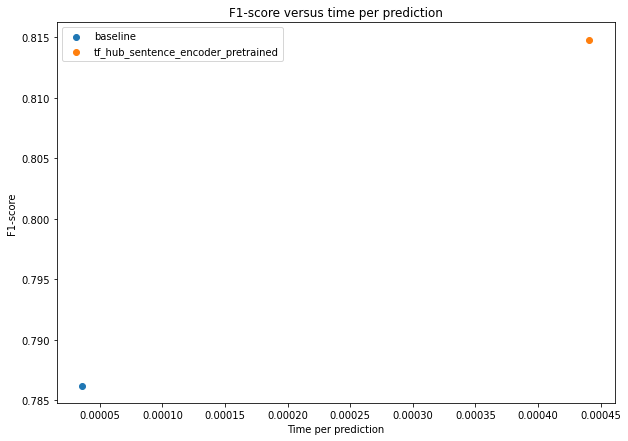

In [162]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results['f1'], label='baseline')
plt.scatter(model_6_time_per_pred, model_6_pretrained_results['f1'], label='tf_hub_sentence_encoder_pretrained')
plt.legend()
plt.title('F1-score versus time per prediction')
plt.xlabel('Time per prediction')
plt.ylabel('F1-score');